Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

In [1]:
# core UW bit
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
from UWGeodynamics.scaling import units as u
from UWGeodynamics.scaling import dimensionalise
from UWGeodynamics.scaling import non_dimensionalise as nd

loaded rc file /home/jovyan/workspace/codes/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# 3rd party python modules
import math
import numpy as np
import os
import scipy

In [3]:
import geo_model_properties as modprop
import relrho_geo_material_properties as matprop

In [4]:
# shortcuts for parallel wrappers
barrier = GEO.uw.mpi.barrier
rank    = GEO.rank

In [5]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
barrier()

In [6]:
# Scaling
%run geo-moresi-2014-scaling.ipynb
scaling_coefficients

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],125000000000.0 second
[substance],1.0 mole


In [7]:
GEO.scaling.get_coefficients()

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],125000000000.0 second
[substance],1.0 mole


In [8]:
dimensionalise(10.,u.meters)

10000000.0 <Unit('meter')>

In [9]:
non_dimensionalise(100.*u.megapascal)

0.125

In [10]:
# double check scaling
if rank == 0:
    print("Value of 0.1 as a stress = ",
          dimensionalise(0.1,u.megapascal))
    
    
    print("Dimensionless Value of 100*u.megapascal is = ", 
          nd(100.*u.megapascal))


Value of 0.1 as a stress =  79.99999999999999 megapascal
Dimensionless Value of 100*u.megapascal is =  0.125


**Setup parameters**


In [11]:
# xRes = 256
# yRes =  96 
# zRes =  96

xRes = 64
yRes =  8
zRes = 16

dim = 3

checkpoint_restart = False
if checkpoint_restart == True:
    # you need to define these
    outputPath_restart = os.path.join(os.path.abspath("."),"output_checkPoint_restart/")
    time = 4.38067181e+03
    step = 1

In [12]:
# # Domain
# boxLength = nd(modprop.boxLength)
# boxHeight = nd(modprop.boxHeight)
# boxWidth  = nd(modprop.boxWidth)

**Create mesh and finite element variables**

In [13]:
# if dim==2:
#     elementRes  = (xRes, yRes)
#     minCoord    = (0., -nd(boxHeight)) 
#     maxCoord    = (nd(boxLength), 0.)
# else:
#     elementRes  = (xRes, yRes, zRes)
#     minCoord    = (0., -nd(boxHeight), 0.) 
#     maxCoord    = (nd(boxLength), 0., nd(boxWidth))

# mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
#                                  elementRes  = elementRes, 
#                                  minCoord    = minCoord,
#                                  maxCoord    = maxCoord,
#                                ) 

In [14]:
# Domain
boxLength = modprop.boxLength
boxHeight = modprop.boxHeight
boxWidth  = modprop.boxWidth

In [15]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    elementRes = (xRes, yRes)
    minCoord   = (0., -boxHeight)
    maxCoord   = (boxLength, 0.)
    z_hat = ( 0.0, 1.0)
    
else:
    elementRes = (xRes, yRes, zRes)
    minCoord   = (0., -boxHeight, 0.)
    maxCoord   = (boxLength, 0., boxWidth)
    z_hat = ( 0.0, 1.0, 0.0 )
    
Model = GEO.Model(elementRes = elementRes,
                  minCoord   = minCoord,
                  maxCoord   = maxCoord,
                  gravity    = z_hat )

### Questions: _postSoftening_

This looks like a 'hasYielded' swarm variable. It is a bool, initially set to 0 and set to 1 iff the particle has yielded at any stage. Once triggered a 1 can't heal back to 0. It enables a bifurication of the cohesion value used in the vonMises yield criterion.

I could add a swarm variable for _postSoftening_ variable in the original model of Bec's
`Model.add_swarm_variable`

or is the `_ViscosityFunction._isYielding` from `UWGeo`

In [16]:
# velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
# pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

**Create a particle swarm**

In [17]:
# particlesPerCell = 20
# swarm       = uw.swarm.Swarm( mesh=mesh )

# materialIndex = swarm.add_variable( dataType="int", count=1 )
# postSoftening = swarm.add_variable( dataType="int", count=1 )  

**checkpoint_restart**

In [18]:
# # if reloading from checkpoint
if checkpoint_restart == True:
    swarm.load(         outputPath_restart+'swarm.'         + str(step).zfill(5) +'.h5')
    materialIndex.load( outputPath_restart+'materialIndex.' + str(step).zfill(5) +'.h5')
    postSoftening.load( outputPath_restart+'postSoftening.' + str(step).zfill(5) +'.h5')
else:
#     swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=particlesPerCell )
#     swarm.populate_using_layout( layout=swarmLayout )
#     postSoftening.data[:] = 0 # initial softening flag to False
    %run geo-moresi-2014-material-layout.ipynb
    %run relrho_geo_material_properties.py
#     if dim == 2:
#         materialIndex.data[:] = fn.branching.conditional( conditions_2d ).evaluate(Model.swarm)
#     else:
#         materialIndex.data[:] = fn.branching.conditional( conditions_3d ).evaluate(swarm)
    

In [19]:
# search through layout file and link geometries to materials
# ie conditions_3d -> material_list
### CAN 
# 
below_150km = Model.y < nd(-150.*u.kilometers)

for i in reversed(conditions_3d):  # IMPORTANT 'reversed'
    index = i[1]                   # find material index
    for x in material_list:        # if index in material_list
        if x["index"] == index:    # create material with Polygon() shape
            print("Creating", x["name"])
            m = Model.add_material(name=x["name"], shape=i[0])
            
            m.density   = x["density"]
            m.viscosity = x["viscosity"]
            
            c0 = x["cohesion"]
            c2 = x["cohesion2"] if x.get('cohesion2') else None
            m.plasticity = GEO.VonMises(cohesion = c0,
                                        cohesionAfterSoftening = c2)


Creating upper mantle
Creating craton2
Creating craton1
Creating trans2
Creating trans1
Creating backArc2
Creating backArc1
Creating oceanic plate 4
Creating oceanic plate 3
Creating oceanic plate 2
Creating oceanic plate 1
Creating buoyStrip
Creating lower mantle


**Eclogite transition**

Assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km

In [20]:
# We predefine the phase change material by hand
# because it does't exist initially.
# The phase change is between 
# 'oceanic plate 1' -> 'oceanic plate 1 after phase change'
# see file geo_material_properties.py

# Get the phase change by hand
m = material_list[3]
# register new material
op_change = Model.add_material(name=m["name"])
op_change.density   = m["density"]
op_change.viscosity = m["viscosity"]
c0 = m["cohesion"]
c2 = m["cohesion2"] if m.get('cohesion2') else None
op_change.plasticity = GEO.VonMises(cohesion = c0,
                            cohesionAfterSoftening = c2)

# now assign a `PhaseChange` to the newly registered material
for m in Model.materials:
    if m.name == "oceanic plate 1":
        break
m.phase_changes = GEO.PhaseChange( (Model.y < nd(-150.*u.kilometers)),
                                  op_change.index) 

In [23]:
for m in material_list:
#     print(m["name"], (m["density"].magnitude-132.5847)/(132.5847))
    print(m["name"], m["density"])

upper mantle 0.0
lower mantle 0.0
oceanic plate 1 -0.3388
oceanic plate 1 after phase change 1.107
oceanic plate 2 0.604
oceanic plate 3 0.3849
oceanic plate 4 0.2228
backArc1 -1.198
backArc2 0.1162
trans1 -1.977
trans2 0.255
craton1 -2.118
craton2 0.2533
ribbon -2.11
buoyStrip -2.11


In [24]:
matprop.ref_density.magnitude

132.5847


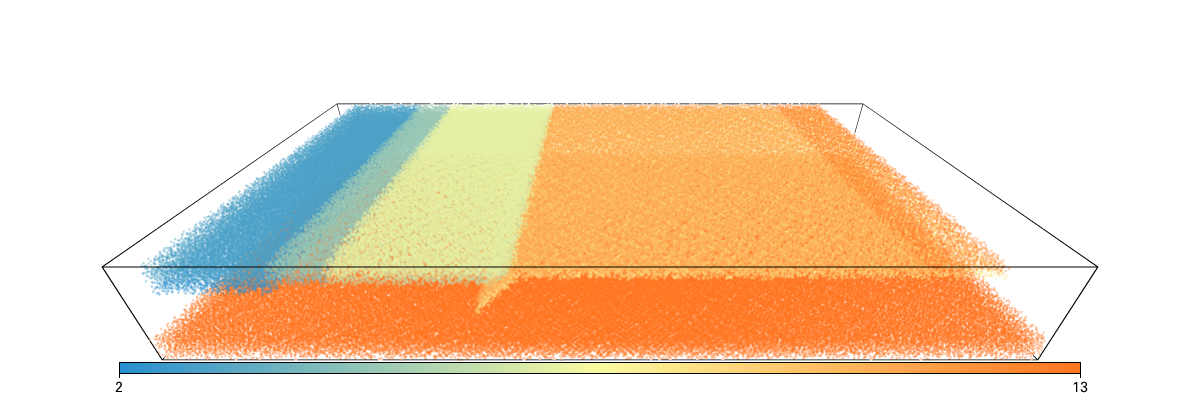

In [25]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 1


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
Fig.script(camera)

# Render in notebook
Fig.show()

In [26]:
# build 3D surface tracers, ie y=0. NOT available for 2D
def tracer_coords(name, minX, maxX, minZ, maxZ):
    
    xx = np.linspace(minX, maxX, max(1, int(maxX-minX))*100)
    yy = np.zeros(1)
    zz = np.linspace(minZ, maxZ, max(1, int(maxX-minX))*100)

    xx, yy, zz = np.meshgrid(xx,yy,zz)
        
    tracers = Model.add_passive_tracers(name,
                                        vertices  = [0.,0.,0.],
                                        centroids = [xx, yy, zz]) 

In [27]:
# Over-riding plate particles
tracer_coords("orp", nd(backarc_xStart),nd(slab_xStart),
              0., nd(boxWidth))
tracer_coords("slab",nd(slab_xStart),nd(bouyStrip_xStart),
              0., nd(slab_dz))
tracer_coords("cont", nd(craton_xStart), nd(backarc_xStart),
              0., nd(boxWidth))
tracer_coords("arc", nd(ribbon_xStart), nd(ribbon_xStart+ribbon_dx),
              nd(ribbon_dz), nd(boxWidth))
tracer_coords("buoy", nd(bouyStrip_xStart), nd(slab_xStart+slab_dx),
              0., nd(slab_dz))

In [28]:
on_grid_x = fn.math.sin(10.*np.pi*Model.x) > 0.9
on_grid_y = fn.math.sin(10.*np.pi*Model.z) > 0.9

grid_conditions = [  
                    ( on_grid_x, 1.),
                    ( on_grid_y, 1.),
                    ( True, -1.),
                  ]

for t in Model.passive_tracers.items():
    new_var = t[1].add_variable(dataType="float", count=1)
    new_var.data[:] = fn.branching.conditional(grid_conditions).evaluate(t[1])

In [29]:
Model.passive_tracers.keys()

odict_keys(['orp', 'slab', 'cont', 'arc', 'buoy'])


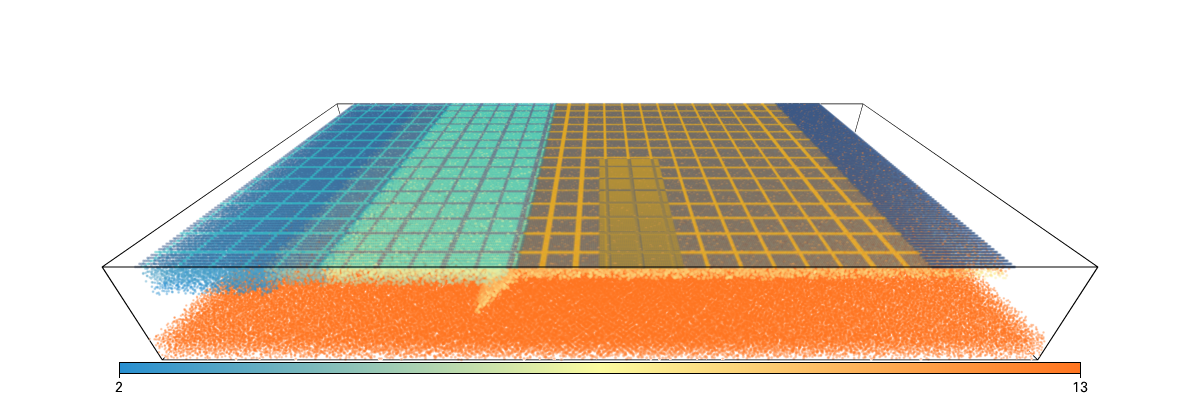

In [30]:
FigTracers = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
FigTracers.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

def get_show_tracer(name, colours):
    t = Model.passive_tracers.get(name)
    if not t: raise RuntimeError("ERROR: fine tracer called ", name)
    
    FigTracers.Points(t, t.variables[-1],fn_size=2.,
                      colours=colours,opacity=0.5,colourBar=False)
    
if dim == 3:
    
    get_show_tracer(name='orp', colours="#22BBBB #335588")
    get_show_tracer(name='slab', colours="Gray40 Goldenrod")
    get_show_tracer(name='cont', colours="#335588 #22BBBB")
    get_show_tracer(name='arc', colours="Goldenrod Grey41")
    get_show_tracer(name='buoy', colours="#335588 #335588")

# Rotate camera angle
FigTracers.script(camera)

# Render in notebook
FigTracers.show()

In [ ]:
# # if restarting from checkpoint
# if checkpoint_restart==True:
#     if dim == 3:
#         swarm_orp.load( outputPath_restart+'swarm_orp.' + str(step).zfill(5) +'.h5')
#         swarm_slab.load(outputPath_restart+'swarm_slab.'+ str(step).zfill(5) +'.h5')
#         swarm_arc.load( outputPath_restart+'swarm_arc.' + str(step).zfill(5) +'.h5')
#         swarm_cont.load(outputPath_restart+'swarm_cont.'+ str(step).zfill(5) +'.h5')
#         swarm_buoy.load(outputPath_restart+'swarm_buoy.'+ str(step).zfill(5) +'.h5')

#         grid_orp.load( outputPath_restart +'grid_orp.'  + str(step).zfill(5) +'.h5')
#         grid_slab.load(outputPath_restart +'grid_slab.' + str(step).zfill(5) +'.h5')
#         grid_arc.load( outputPath_restart +'grid_arc.'  + str(step).zfill(5) +'.h5')
#         grid_cont.load(outputPath_restart +'grid_cont.' + str(step).zfill(5) +'.h5')
#         grid_buoy.load(outputPath_restart +'grid_buoy.' + str(step).zfill(5) +'.h5')

In [31]:
Model.minViscosity = dimensionalise(1., u.Pa * u.sec)
Model.maxViscosity = dimensionalise(1e5, u.Pa * u.sec)

In [32]:
Model.set_velocityBCs( left=[0.,None,None], right=[0.,None,None],
                       bottom=[None,0.,None], top=[None,0.,None],
                       front=[None,None,0.], back=[None,None,0.])

In [33]:
Model.init_model()

In [ ]:
# figViscosity = vis.Figure(figsize=figsize, axis=True)
# figViscosity.append( vis.objects.Points(swarm, viscosityFn, colours='dem1', fn_size=2., logScale=True) )
# if dim == 3:
#     figViscosity.script(camera)
# figViscosity.show()


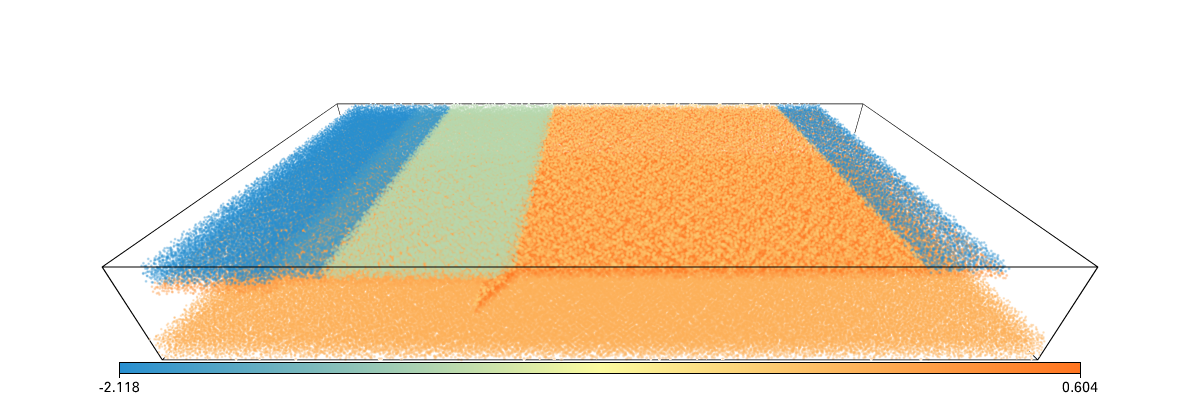

In [34]:
Fig = vis.Figure(figsize=(1200,400))

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.densityField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Rotate camera angle
Fig.script(camera)

# Render in notebook
Fig.show()

In [35]:
# # set initial conditions (and boundary values)
# if checkpoint_restart == False:
#     if dim==2:
#         velocityField.data[:] = [0.,0.]
#     else:
#         velocityField.data[:] = [0.,0.,0.]
#     pressureField.data[:] = 0.
# else:
#     velocityField.load(outputPath_restart+'velocityField.'+ str(step).zfill(5) +'.h5')
#     pressureField.load(outputPath_restart+'pressureField.'+ str(step).zfill(5) +'.h5')

NameError: name 'velocityField' is not defined

In [ ]:
# # sent boundary condition information to underworld
# iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
# jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
# if dim==2:
#     freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
#                                                    indexSetsPerDof = ( iWalls, jWalls) ) 
    
# if dim==3:
#     kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]    
#     freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
#                                                    indexSetsPerDof = ( iWalls, jWalls, kWalls) ) 

**System Setup**

In [ ]:
# # Initial linear slab viscosity setup
# stokes = uw.systems.Stokes(    velocityField = velocityField, 
#                                pressureField = pressureField,
#                                voronoi_swarm = swarm, 
#                                conditions    = freeSlipBC,
#                                fn_viscosity  = viscosityFn, 
#                                fn_bodyforce  = buoyancyFn )
# # Create solver & solve
# solver = uw.systems.Solver(stokes)

In [ ]:
Model.run_for(nstep=2)

Running with UWGeodynamics version 2.9.0
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05


In [ ]:
# System level solver options
solver.options.main.Q22_pc_type = "uwscale"
solver.options.main.ksp_k2_type = "GMG"
solver.options.main.ksp_type    = "bsscr"
solver.options.main.pc_type     = "none"
solver.options.main.penalty     = 50.
#solver.options.main.list()

In [ ]:
# Schur complement solver options
solver.options.scr.ksp_rtol = 1.0e-3 
solver.options.scr.ksp_type = "fgmres"
#solver.options.main.list()

In [ ]:
# Inner solve (velocity), A11 options
solver.options.A11.ksp_rtol = 1.0e-4
solver.options.A11.ksp_type = "fgmres"
#solver.options.A11.list()

In [ ]:
solver.print_petsc_options()

In [36]:
# use "lu" direct solve if running in serial
if(uw.nProcs==1):
    solver.set_inner_method("lu")

NameError: name 'uw' is not defined

In [ ]:
advector  = uw.systems.SwarmAdvector( swarm=swarm,      velocityField=velocityField, order=2 )
if dim == 3:
    advector2 = uw.systems.SwarmAdvector( swarm=swarm_orp,  velocityField=velocityField, order=2 )
    advector3 = uw.systems.SwarmAdvector( swarm=swarm_slab, velocityField=velocityField, order=2 )
    advector4 = uw.systems.SwarmAdvector( swarm=swarm_arc,  velocityField=velocityField, order=2 )
    advector5 = uw.systems.SwarmAdvector( swarm=swarm_cont, velocityField=velocityField, order=2 )
    advector6 = uw.systems.SwarmAdvector( swarm=swarm_buoy, velocityField=velocityField, order=2 )

**Analysis tools**

In [ ]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

In [ ]:
figSwarm.append(vis.objects.VectorArrows(mesh, velocityField))
figViscosity.append(vis.objects.VectorArrows(mesh, velocityField))

**Checkpoint**

In [ ]:
# save mesh
meshHnd = mesh.save(outputPath+'mesh.h5')

In [ ]:
# define checkpointing file
def checkpoint():
    # save swarms
    swarmHnd      = swarm.save(     outputPath+'swarm.'     + str(step).zfill(5) +'.h5')

    # save swarm variables
    materialIndexHnd = materialIndex.save(  outputPath +'materialIndex.' + str(step).zfill(5) +'.h5')
    postSofteningHnd = postSoftening.save(  outputPath +'postSoftening.' + str(step).zfill(5) +'.h5')
    
    # save mesh variable
    velocityHnd = velocityField.save(outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd = pressureField.save(outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

    # and the xdmf files
    velocityField.xdmf(outputPath+'velocityField.' +str(step).zfill(5)+'.xdmf',velocityHnd,      "velocity",      meshHnd, "mesh", modeltime=time)
    pressureField.xdmf(outputPath+'pressureField.' +str(step).zfill(5)+'.xdmf',pressureHnd,      "pressure",      meshHnd, "mesh", modeltime=time)

    materialIndex.xdmf(outputPath+'materialIndex.' +str(step).zfill(5)+'.xdmf',materialIndexHnd, "materialIndex", swarmHnd,"swarm",modeltime=time)
    postSoftening.xdmf(outputPath+'postSoftening.' +str(step).zfill(5)+'.xdmf',postSofteningHnd, "postSoftening", swarmHnd,"swarm",modeltime=time)
    
    if dim == 3:
        swarmHnd_orp      = swarm_orp.save( outputPath+'swarm_orp.' + str(step).zfill(5) +'.h5')
        swarmHnd_slab     = swarm_slab.save(outputPath+'swarm_slab.'+ str(step).zfill(5) +'.h5')
        swarmHnd_arc      = swarm_arc.save( outputPath+'swarm_arc.' + str(step).zfill(5) +'.h5')
        swarmHnd_cont     = swarm_cont.save(outputPath+'swarm_cont.'+ str(step).zfill(5) +'.h5')
        swarmHnd_buoy     = swarm_buoy.save(outputPath+'swarm_buoy.'+ str(step).zfill(5) +'.h5')

        gridHnd_orp       = grid_orp.save(  outputPath +'grid_orp.' + str(step).zfill(5) +'.h5')
        gridHnd_slab      = grid_slab.save( outputPath +'grid_slab.'+ str(step).zfill(5) +'.h5')
        gridHnd_arc       = grid_arc.save(  outputPath +'grid_arc.' + str(step).zfill(5) +'.h5')
        gridHnd_cont      = grid_cont.save( outputPath +'grid_cont.'+ str(step).zfill(5) +'.h5')
        gridHnd_buoy      = grid_buoy.save( outputPath +'grid_buoy.'+ str(step).zfill(5) +'.h5')

        grid_orp.xdmf( outputPath+'grid_orp.' +str(step).zfill(5)+'.xdmf',gridHnd_orp, "grid_orp", swarmHnd_orp, "swarm_orp", modeltime=time)
        grid_slab.xdmf(outputPath+'grid_slab.'+str(step).zfill(5)+'.xdmf',gridHnd_slab,"grid_slab",swarmHnd_slab,"swarm_slab",modeltime=time)
        grid_arc.xdmf( outputPath+'grid_arc.' +str(step).zfill(5)+'.xdmf',gridHnd_arc, "grid_arc", swarmHnd_arc, "swarm_arc", modeltime=time)
        grid_cont.xdmf(outputPath+'grid_cont.'+str(step).zfill(5)+'.xdmf',gridHnd_cont,"grid_cont",swarmHnd_cont,"swarm_cont",modeltime=time)
        grid_buoy.xdmf(outputPath+'grid_buoy.'+str(step).zfill(5)+'.xdmf',gridHnd_buoy,"grid_buoy",swarmHnd_buoy,"swarm_buoy",modeltime=time)
    


Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [ ]:
if checkpoint_restart==False:
    time = 0  # Initial time
    step = 0   # Initial timestep

maxSteps = 2       # Maximum timesteps 
steps_output = 1   # output every X timesteps
checkoutput  = 1

In [ ]:
if(rank==0):
    with open(outputPath+'FrequentOutput.dat','a') as f:
         f.write('step\t time\t time(yr)\t Vrms\t Vrms(cm/yr)\n')

In [ ]:
def update_postSoftening():
    # if yeilded with postSoften==0,
    vonMises_data          = vonMises.evaluate(swarm)
    linearViscosityFn_data = linearViscosityFn.evaluate(swarm)
    for i, x in enumerate(swarm.data[:]):
         if vonMises_data[i] < linearViscosityFn_data[i]:
                #print i, vonMises_data[i], linearViscosityFn_data[i]
                postSoftening.data[i] = 1

In [ ]:
# define an update function
def update():
    update_postSoftening()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    if dim == 3:
        advector2.integrate(dt)
        advector3.integrate(dt)
        advector4.integrate(dt)
        advector5.integrate(dt)
        advector6.integrate(dt)
    return time+dt, step+1

In [ ]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True, nonLinearMaxIterations=15, print_stats=True)
    
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(  outputPath + "density"     + str(step).zfill(4))
        
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    if(rank==0):
        with open(outputPath+'FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, dimensionalise(time, u.year).magnitude, Vrms, dimensionalise(Vrms, u.centimeter/u.year).magnitude)), fmt='%.8e')
        print('step = {0:6d};\t time = {1:.3e};\t , time(yr) = {2:.3e};\t Vrms = {3:.3e};\t'.format(step, time, dimensionalise(time, u.year).magnitude, Vrms))

    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()
    

In [ ]:
# if not vis.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
# lv = figSwarm.window()
# lv.rotate(30)
# lv.zoom(-7)
# lv.redisplay()
# lv.axis()

In [ ]:
figPostSoftening = vis.Figure(figsize=figsize)
figPostSoftening.append( vis.objects.Points(swarm, postSoftening, fn_mask=materialFilter, fn_size=2.))
figPostSoftening.script(camera)
figPostSoftening.show()

In [ ]:
figCohesion.show()

In [ ]:
dimensionalise(time, u.megayear).magnitude

In [ ]:
figViscosity.show()

In [ ]:
figDensity.show()

In [ ]:
figSwarm.show()


In [ ]:
while step < maxSteps*2:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)#, print_stats=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        figSwarm.save(    outputPath + "particle"    + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figDensity.save(     outputPath + "density"     + str(step).zfill(4))
        
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    if(rank==0):
        with open(outputPath+'FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, dimensionalise(time, u.year).magnitude, Vrms, dimensionalise(Vrms, u.centimeter/u.year).magnitude)), fmt='%.8e')
        print('step = {0:6d};\t time = {1:.3e};\t , time(yr) = {2:.3e};\t Vrms = {3:.3e};\t'.format(step, time, dimensionalise(time, u.year).magnitude, Vrms))


    if step % checkoutput == 0:
        checkpoint()
    # update
    time,step = update()

In [ ]:
figSwarm.show()

In [ ]:
figDensity.show()

In [ ]:
figPostSoftening.show()

In [ ]:
figCohesion.show()

In [ ]:
figViscosity.show()